In [158]:
import numpy as np
import pandas as pd
from utils import *

In [159]:
df = load_from_csv('/Users/shamanthk/Documents/iomics/DoWhy-workflow/data/lung_cancer.csv')
df = df.dropna()
df.drop_duplicates(inplace=True)
labels = list(df.columns)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [160]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

cols = df.columns[(df == 1).any() | (df == 2).any()]
df[cols] = df[cols].replace({1: 0, 2: 1})

df['LUNG_CANCER']=encoder.fit_transform(df['LUNG_CANCER'])
df['GENDER']=encoder.fit_transform(df['GENDER'])
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


#### Let's ask the question: Does smoking cause lung cancer?

We should know from a large number of studies that, yes, smoking does cause lung cancer -- how can we test this out using DoWhy?

In [161]:
df = df.astype(float)
df.shape

In [162]:
import dowhy

In [163]:
data = df.to_numpy()
data

array([[ 1., 69.,  0., ...,  1.,  1.,  1.],
       [ 1., 74.,  1., ...,  1.,  1.,  1.],
       [ 0., 59.,  0., ...,  0.,  1.,  0.],
       ...,
       [ 1., 55.,  1., ...,  0.,  1.,  0.],
       [ 1., 46.,  0., ...,  1.,  1.,  0.],
       [ 1., 60.,  0., ...,  1.,  1.,  1.]])

#### First let us choose a candidate model

However, to do so, we should consider a few of the main causal discovery algorithms

In [164]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot
from causallearn.search.ConstraintBased.FCI import fci


For now, let us stick to direct LiNGAM for purposes of demonstration.

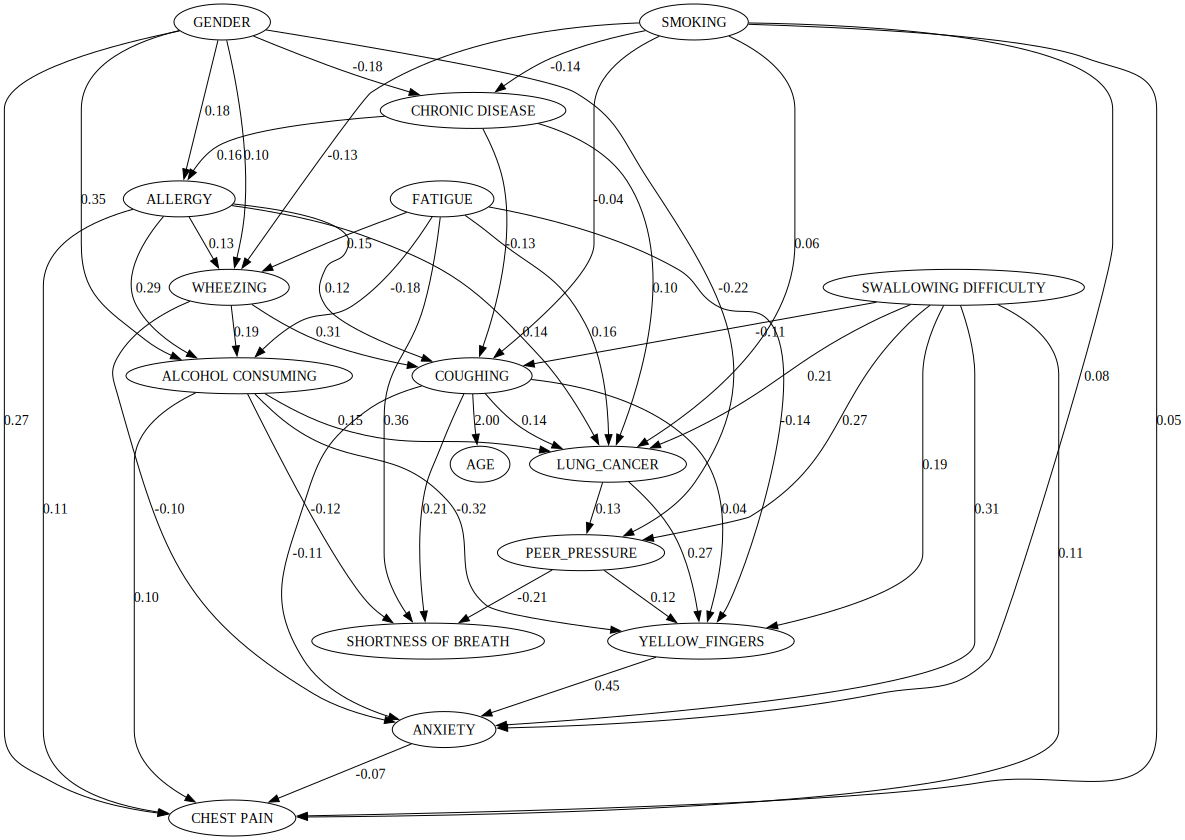

In [165]:
model = lingam.ICALiNGAM()
model.fit(data)

make_dot(model.adjacency_matrix_, labels=labels)

In [166]:
dot = make_dot(model.adjacency_matrix_, labels=labels)
dot.save('temp.dot')
predicted_graph_lingam = nx.drawing.nx_agraph.read_dot('temp.dot')

Test permutations of given graph: 100%|██████████| 200/200 [01:16<00:00,  2.61it/s]


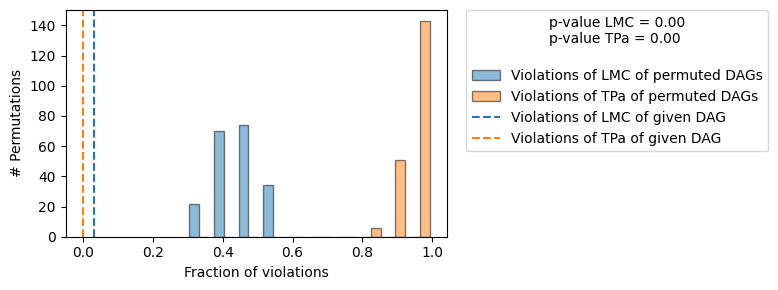

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 200 of the permutations lie in the Markov                    |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 3/94 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
|                                             

In [167]:
import dowhy.gcm.falsify
from dowhy.gcm.falsify import falsify_graph

# causal_graph is a networkx digraph
results = falsify_graph(predicted_graph_lingam, df, n_permutations=200,
                              independence_test=gcm,
                              conditional_independence_test=gcm,
                              plot_histogram=True, suggestions=True)
print(results)

In [168]:
from dowhy.gcm.falsify import apply_suggestions

predicted_graph_lingam = apply_suggestions(predicted_graph_lingam, results)

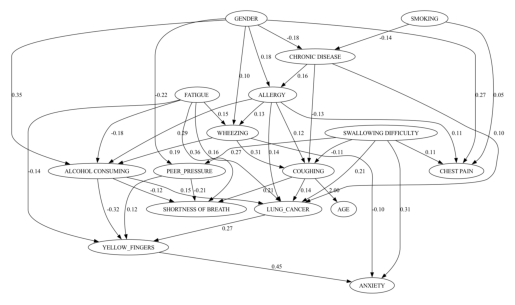

In [169]:
disp_graph_nx(predicted_graph_lingam)

In [170]:
nx.write_gml(predicted_graph_lingam, '/Users/shamanthk/Documents/iomics/DoWhy-workflow/lingam.gml')

In [171]:
from dowhy import CausalModel

model_est=CausalModel(
        data = df,
        treatment='SMOKING',
        outcome='LUNG_CANCER',
        graph='lingam.gml')

In [172]:
identified_estimand = model_est.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                     
──────────(E[LUNG_CANCER])
d[SMOKING]                
Estimand assumption 1, Unconfoundedness: If U→{SMOKING} and U→LUNG_CANCER then P(LUNG_CANCER|SMOKING,,U) = P(LUNG_CANCER|SMOKING,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [173]:
estimate = model_est.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 0.019877749475577078


In [177]:
estimate.get_confidence_intervals()

In [178]:
estimate.interpret()

Increasing the treatment variable(s) [SMOKING] from 0 to 1 causes an increase of 0.019877749475577078 in the expected value of the outcome [['LUNG_CANCER']], over the data distribution/population represented by the dataset.


In [174]:
refute_placebo_treatment = model_est.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)

print(refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:0.019877749475577078
New effect:0.0025810733097908376
p value:0.8999999999999999



In [175]:
res_random=model_est.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates: 100%|██████████| 100/100 [00:01<00:00, 99.42it/s]

Refute: Add a random common cause
Estimated effect:0.019877749475577078
New effect:0.019966268457355815
p value:0.94



In [176]:
res_subset=model_est.refute_estimate(identified_estimand, estimate,
       method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

Refuting Estimates: 100%|██████████| 100/100 [00:00<00:00, 113.50it/s]

Refute: Use a subset of data
Estimated effect:0.019877749475577078
New effect:0.021676847811988195
p value:0.8999999999999999

